<a href="https://colab.research.google.com/github/stellaw1/400q-project/blob/main/400QQiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install scikit-learn
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 K

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, ADAM
from qiskit.circuit import ParameterVector, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split
import itertools

# Layer Definitions

### QCNN

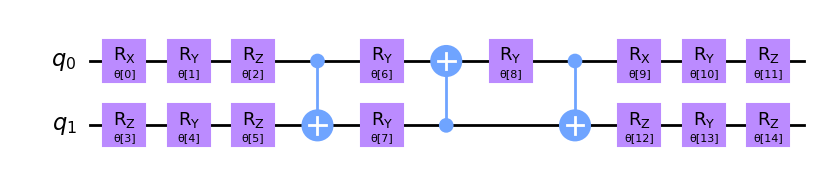

In [ ]:
def conv_circuit(params):
    circuit = QuantumCircuit(2, name="conv layer")
    # U1
    circuit.rx(params[0], 0)
    circuit.ry(params[1], 0) 
    circuit.rz(params[2], 0) 

    # U2
    circuit.rz(params[3], 1)
    circuit.ry(params[4], 1)
    circuit.rz(params[5], 1)

    # entanglement
    circuit.cx(0,1) 
    circuit.ry(params[6], 0)
    circuit.ry(params[7], 1)
    circuit.cx(1,0) 
    circuit.ry(params[8], 0)
    circuit.cx(0,1) 
    
    # U1
    circuit.rx(params[9], 0)
    circuit.ry(params[10], 0) 
    circuit.rz(params[11], 0) 

    # U2
    circuit.rz(params[12], 1)
    circuit.ry(params[13], 1)
    circuit.rz(params[14], 1)

    return circuit

# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=15)
circuit = conv_circuit(params)
circuit.draw("mpl")

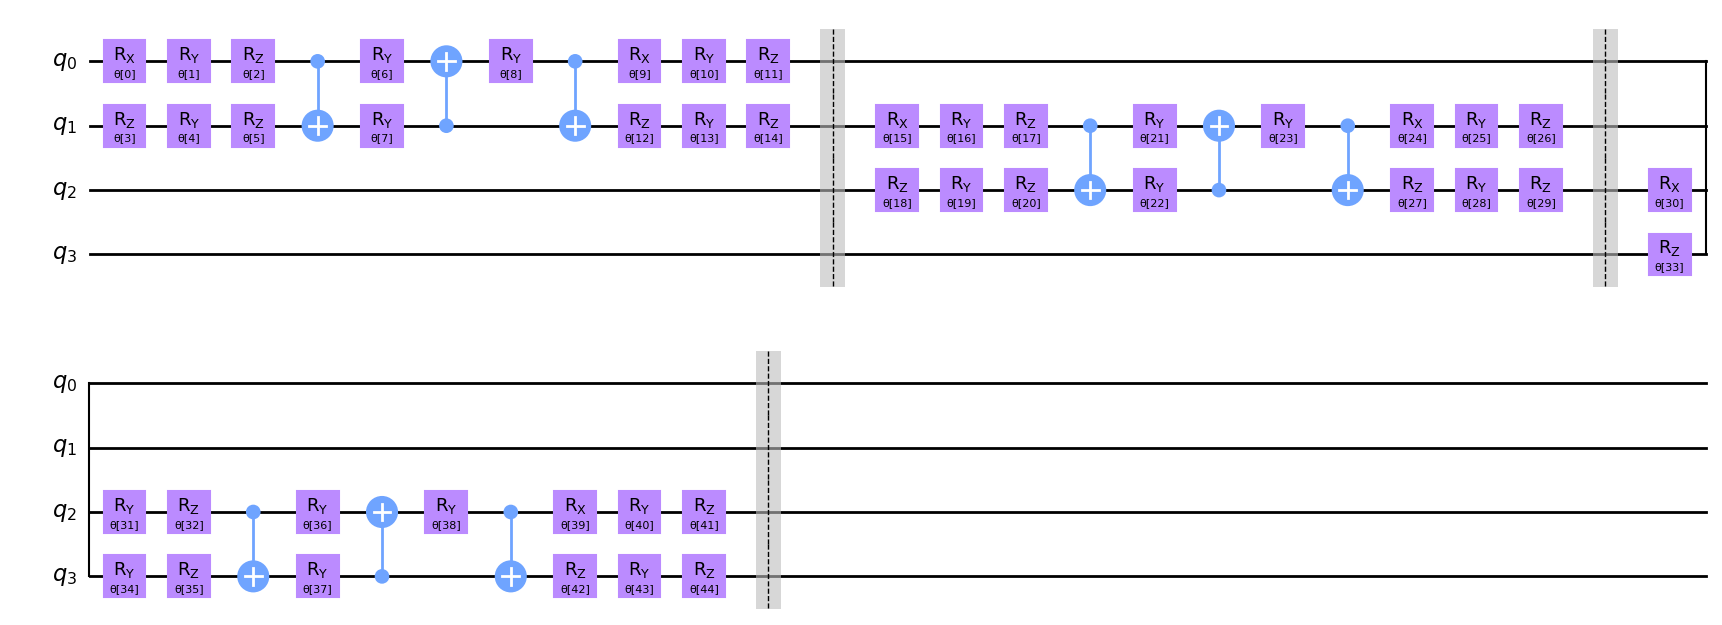

In [ ]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params_per_conv_layer = 15
    params = ParameterVector(param_prefix, length=num_qubits * params_per_conv_layer)
    for q1, q2 in zip(qubits[:-1], qubits[1:]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + params_per_conv_layer)]), [q1, q2])
        qc.barrier()
        param_index += params_per_conv_layer

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

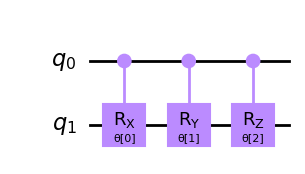

In [ ]:
def pool_circuit(params):
    circuit = QuantumCircuit(2)
    circuit.crx(params[0], 0, 1)
    circuit.cry(params[1], 0, 1)
    circuit.crz(params[2], 0, 1)

    return circuit


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

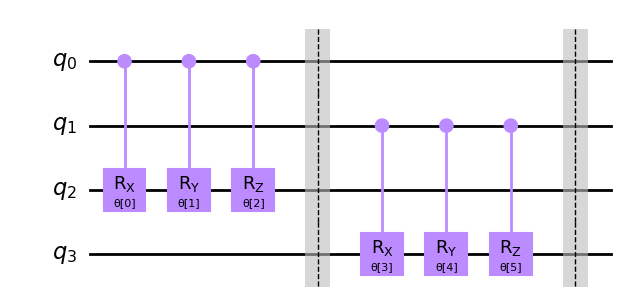

In [ ]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

### bQCNN

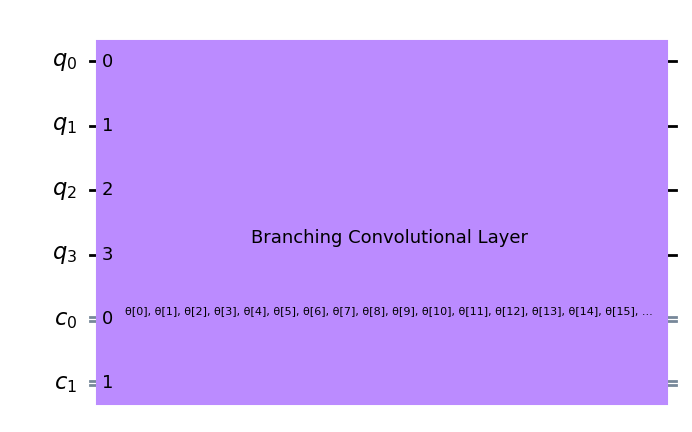

In [ ]:
def branch_conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, num_qubits//2, name="Branching Convolutional Layer")

    qubits = list(range(num_qubits))
    cbits = list(range(num_qubits//2))
    params_per_conv_layer = 15
    number_of_branches = 2 ** (2 * num_qubits // 3)
    params = ParameterVector(param_prefix, length=num_qubits * params_per_conv_layer * number_of_branches)

    # qc.measure([0,1], [0,1])

    branch_permutations = list(itertools.product([0, 1], repeat=2*num_qubits//3))
    for branch in range(2 ** (2 * num_qubits // 3)): # total 2 ^ (2 * L // 3) branches
        qc.append(conv_circuit(params[branch*15:(branch+1)*15]), [2,3]).c_if(cr, branch)
        qc.barrier()

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits, num_qubits // 2)
    qc.append(qc_inst, qubits, cbits)
    return qc

circuit = branch_conv_layer(4, "θ")
circuit.draw("mpl")

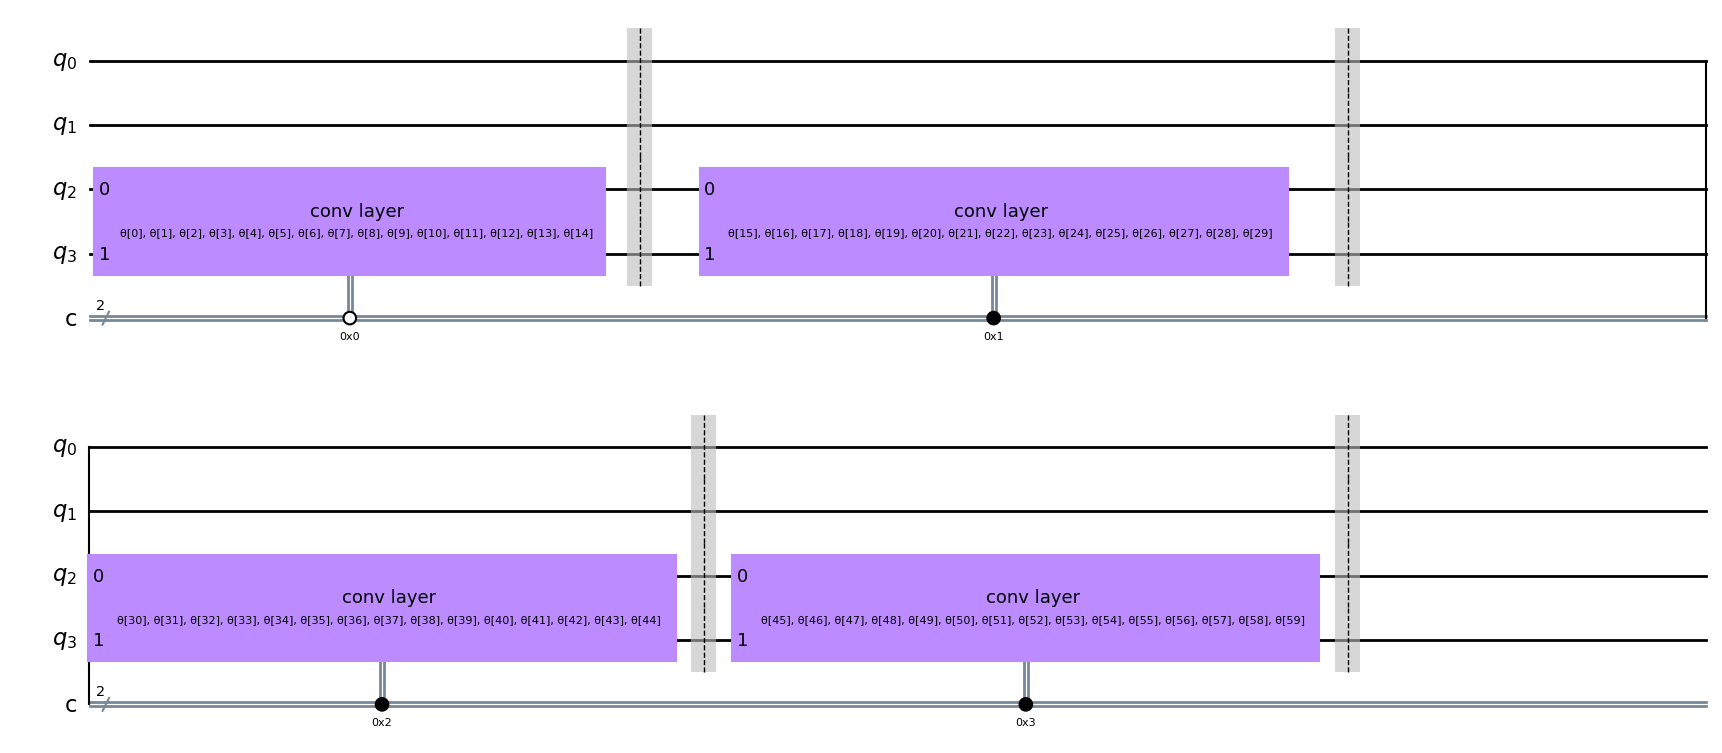

In [ ]:
# detail circuit decomp.
circuit = branch_conv_layer(4, "θ")
circuit.decompose().draw("mpl")

# Data Generation

In [ ]:
def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((2, 4))
    ver_array = np.zeros((2, 4))

    j = 0
    for i in range(0, 3):
        if i != 1:
            hor_array[j][i] = np.pi / 2
            hor_array[j][i + 1] = np.pi / 2
            j += 1
    
    print(hor_array)

    j = 0
    for i in range(0, 2):
        ver_array[j][i] = np.pi / 2
        ver_array[j][i + 2] = np.pi / 2
        j += 1

    for n in range(num_images):
        rng = algorithm_globals.random.integers(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = algorithm_globals.random.integers(0, 2)
            images.append(np.array(hor_array[random_image]))
        elif rng == 1:
            labels.append(1)
            random_image = algorithm_globals.random.integers(0, 2)
            images.append(np.array(ver_array[random_image]))

        # Create noise
        for i in range(4):
            if images[-1][i] == 0:
                images[-1][i] = algorithm_globals.random.uniform(0, np.pi / 4)
    return images, labels

In [ ]:
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3
)

[[1.57079633 1.57079633 0.         0.        ]
 [0.         0.         1.57079633 1.57079633]]


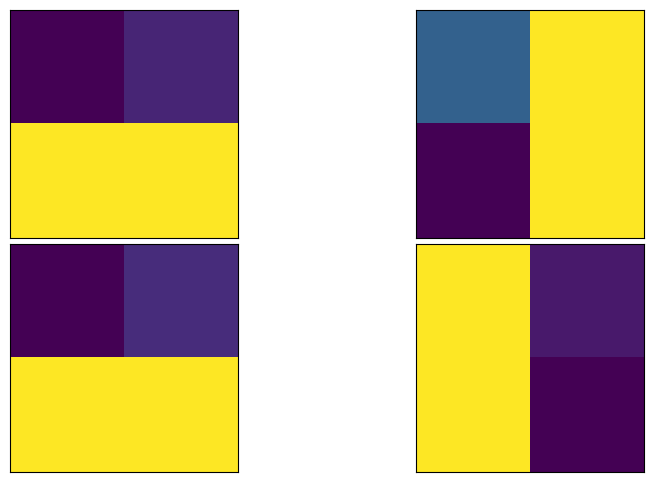

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(2, 2),
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

# Training

### QCNN

In [ ]:
feature_map = ZFeatureMap(4)

ansatz = QuantumCircuit(4, name="QCNN")

# First Convolutional Layer
ansatz.compose(conv_layer(4, "с1"), list(range(4)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0,1], [2,3], "p1"), list(range(4)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(2, "c2"), list(range(2,4)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(2,4)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(4)
circuit.compose(feature_map, range(4), inplace=True)
circuit.compose(ansatz, range(4), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 3, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

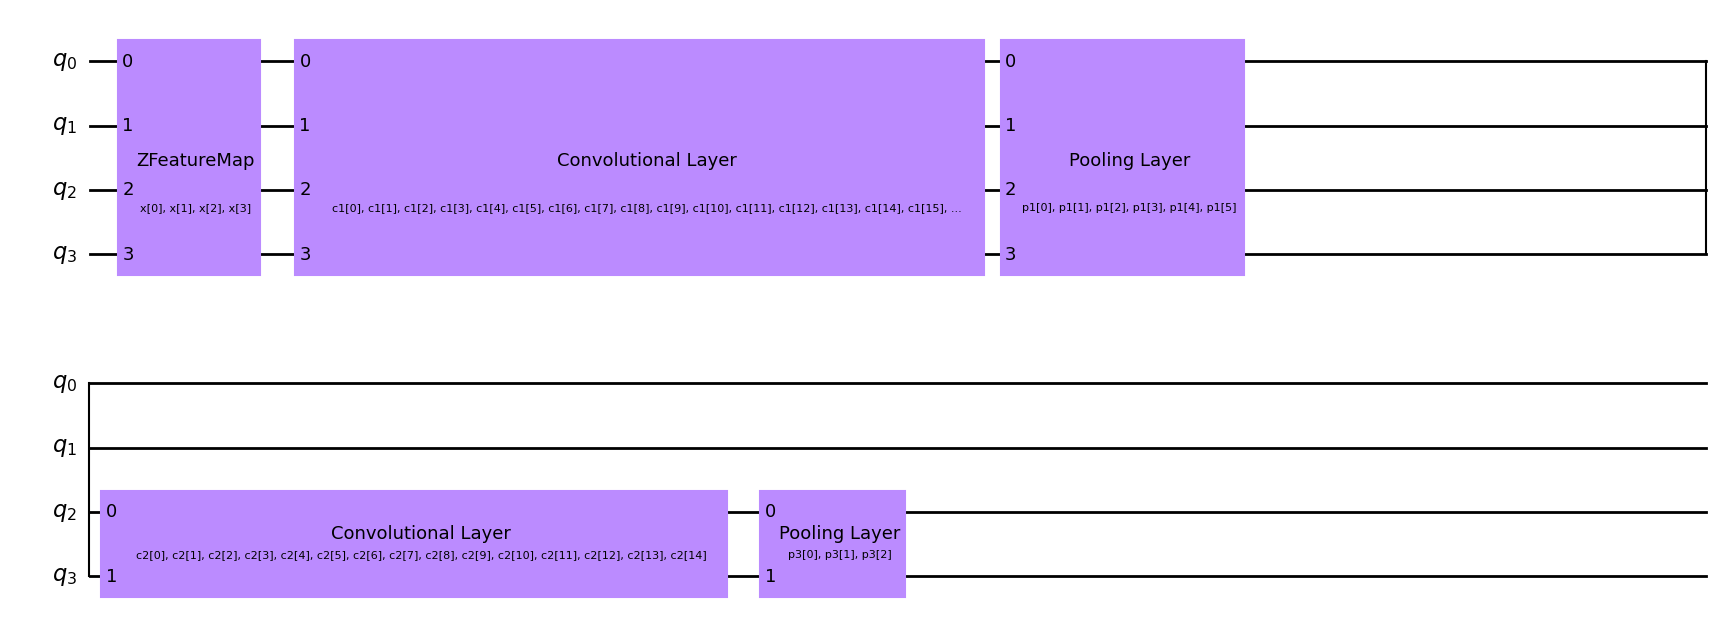

In [ ]:
circuit.draw("mpl")

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
# with open("data.json", "r") as f:
#     initial_point = json.load(f)

qcnn_classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),  # Set max iterations here
    callback=callback_graph,
    # initial_point=initial_point,
)

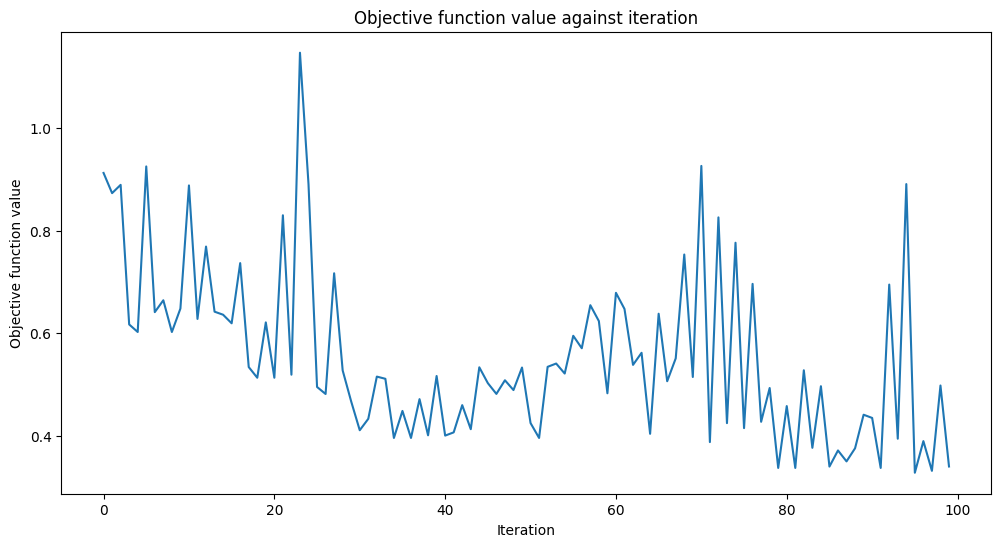

Accuracy from the train data : 97.14%


In [ ]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
qcnn_classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * qcnn_classifier.score(x, y), 2)}%")

Accuracy from the test data : 100.0%


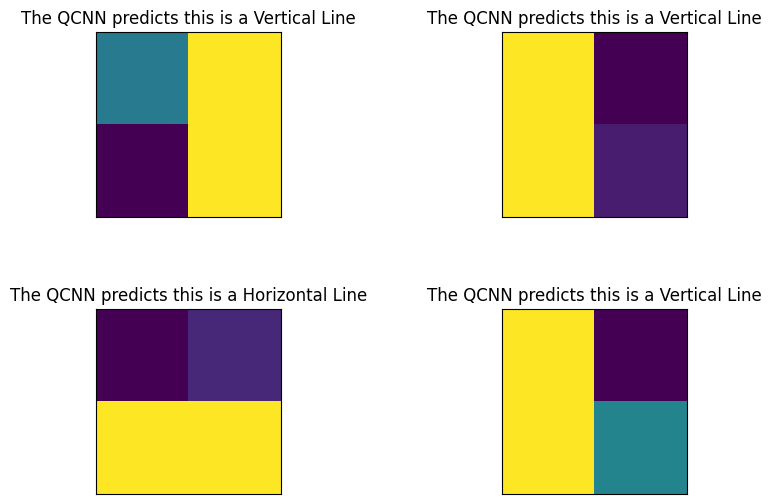

In [ ]:
y_predict = qcnn_classifier.predict(test_images)
x = np.asarray(test_images)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * qcnn_classifier.score(x, y), 2)}%")

# Let's see some examples in our dataset
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(test_images[i].reshape(2, 2), aspect="equal")
    if y_predict[i] == -1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Horizontal Line")
    if y_predict[i] == +1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is a Vertical Line")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

### bQCNN

In [ ]:
feature_map = ZFeatureMap(4)

ansatz = QuantumCircuit(4, name="bQCNN")

# First Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(0, 4)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(0, 4)), inplace=True)

# Second Convolutional Layer
ansatz.compose(branch_conv_layer(4, "c3"), list(range(0, 4)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(2, 4)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(4)
circuit.compose(feature_map, range(4), inplace=True)
circuit.compose(ansatz, range(4), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 3, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
bqcnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

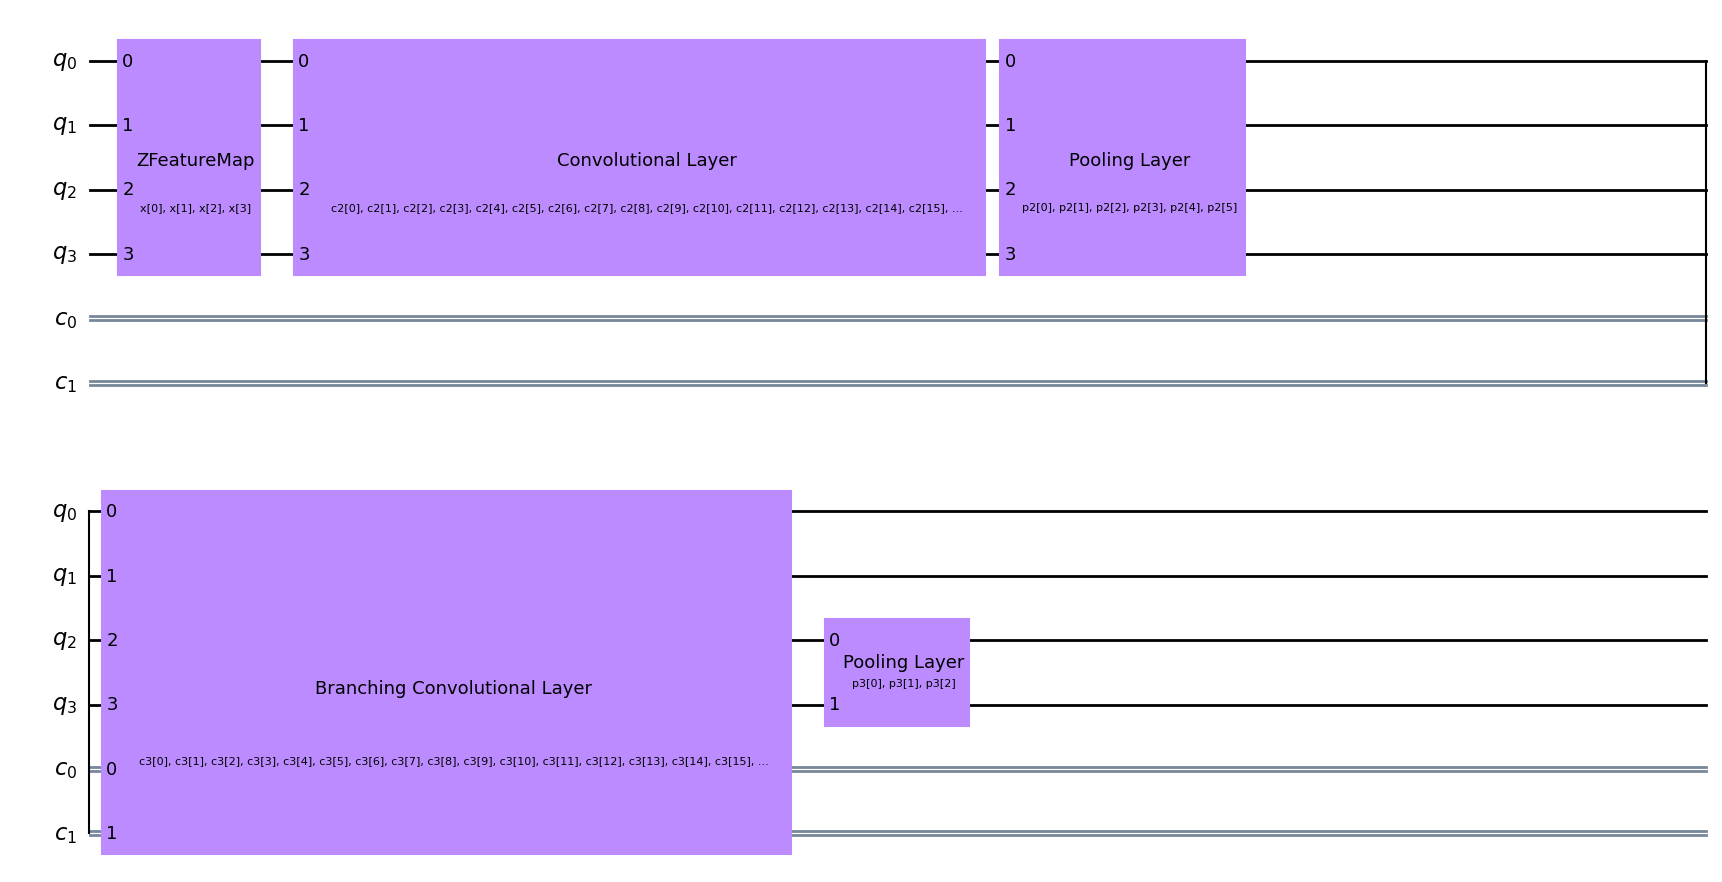

In [ ]:
circuit.draw("mpl")

In [ ]:
bqcnn_classifier = NeuralNetworkClassifier(
    bqcnn,
    optimizer=COBYLA(maxiter=100),  # Set max iterations here
    callback=callback_graph,
    # initial_point=initial_point,
)

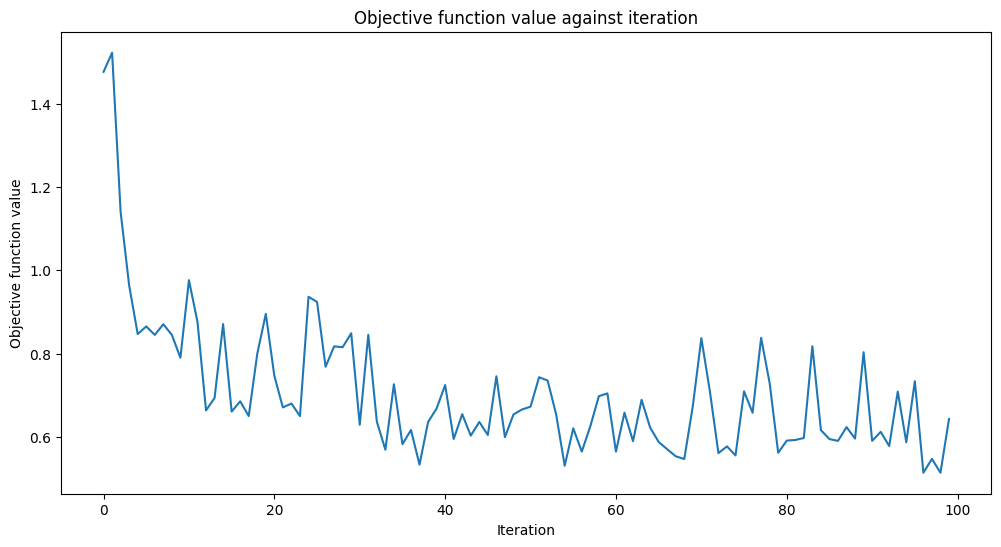

Accuracy from the train data : 82.86%


In [ ]:
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
bqcnn_classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * bqcnn_classifier.score(x, y), 2)}%")